# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [27]:
import numpy as np
import os
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import datetime
import os
import abc

We set the random seed so that the results don't vary drastically.

In [28]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [29]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [30]:
!nvidia-smi

Sun Jul 10 10:01:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 51%   39C    P2   102W / 370W |   1757MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [31]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [32]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # Set directory paths
    def set_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # Set the image properties    
    def set_image_properties(self,image_height=128,image_width=128):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def set_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    #Resize
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [33]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
project_folder='Project_data'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [34]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv2D,MaxPooling2D,Conv3D, MaxPooling3D 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

# Model-1 Conv3D

In [9]:
class Conv3D_Model1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=Conv3D_Model1()
conv_3d1.set_path(project_folder)
conv_3d1.set_image_properties(image_height=128,image_width=128)
conv_3d1.set_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=10)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 64, 64, 32)    0

In [11]:
history=conv_3d1.train_model(conv_3d1_model)

C:\Users\Bhanu prakash\AppData\Local\Temp\ipykernel_23868\672519330.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.4783 - categorical_accuracy: 0.4178
Epoch 1: val_loss improved from inf to 3.26110, saving model to model_init_2022-07-0709_16_45.193364\model-00001-1.47828-0.41780-3.26110-0.21000.h5
34/34 [==============================] - 136s 4s/step - loss: 1.4783 - categorical_accuracy: 0.4178 - val_loss: 3.2611 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.8813 - categorical_accuracy: 0.6516
Epoch 2: val_loss did not improve from 3.26110
34/34 [==============================] - 110s 3s/step - loss: 0.8813 - categorical_accuracy: 0.6516 - val_loss: 5.0372 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.5601 - categorical_accuracy: 0.8069
Epoch 3: val_loss did not improve from 3.26110
34/34 [==============================] - 108s 3s/step - loss: 0.5601 - categorical_accuracy: 0.8069 - val_

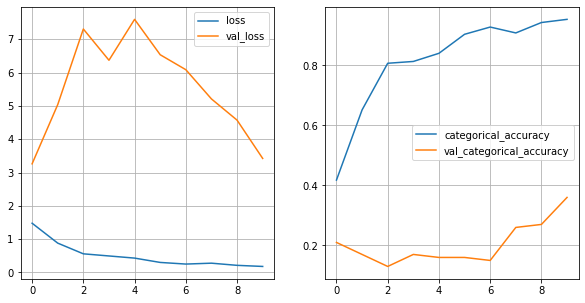

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<b>Observation:</b></br> The above model clearly shows overfitting. 

# Model-2 Conv3D

In [9]:
class Conv3D_Model2(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv3d2=Conv3D_Model2()
conv3d2.set_path(project_folder)
conv3d2.set_image_properties(image_height=128,image_width=128)
conv3d2.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
conv3d2_model=conv3d2.define_model()
print(conv3d2_model.summary())
history2=conv3d2.train_model(conv3d2_model,augment_data=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 64, 64, 32)    0

C:\Users\Bhanu prakash\AppData\Local\Temp\ipykernel_2352\672519330.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7965 - categorical_accuracy: 0.4012
Epoch 1: val_loss improved from inf to 6.54609, saving model to model_init_2022-07-0611_26_06.255424\model-00001-1.79648-0.40121-6.54609-0.16000.h5
67/67 [==============================] - 204s 3s/step - loss: 1.7965 - categorical_accuracy: 0.4012 - val_loss: 6.5461 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.4789
Epoch 2: val_loss did not improve from 6.54609
67/67 [==============================] - 199s 3s/step - loss: 1.4347 - categorical_accuracy: 0.4789 - val_loss: 14.3254 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.2563 - categorical_accuracy: 0.5415
Epoch 3: val_loss did not improve from 6.54609
67/67 [==============================] - 202s 3s/step - loss: 1.2563 - categorical_accuracy: 0.5415 - val

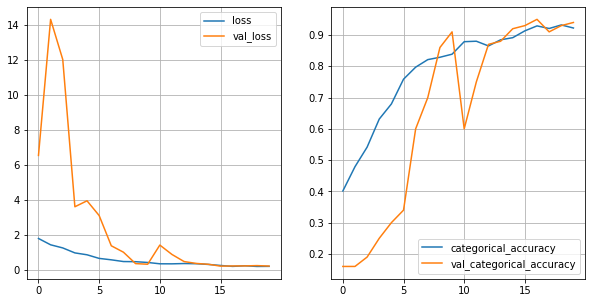

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history2.history['loss'])   
axes[0].plot(history2.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history2.history['categorical_accuracy'])   
axes[1].plot(history2.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<b>Observation:</b></br> In this model I reduced batch size to 10 because i am getting Out of memory error due to increase of dense neurons. In addtion I increased droupout rate to 0,50 and setting image augment to true, the model generalizes well with training accuracy <b>0.91</b> and validation accuracy <b>0.93</b>

# Model-3 CNN_RNN

In [13]:
class RNN_CNN_Model1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn1=RNN_CNN_Model1()
rnn_cnn1.set_path(project_folder)
rnn_cnn1.set_image_properties(image_height=128,image_width=128)
rnn_cnn1.set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model()
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)  

D:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history3=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

C:\Users\Bhanu prakash\AppData\Local\Temp\ipykernel_23868\672519330.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7108 - categorical_accuracy: 0.3220
Epoch 1: val_loss improved from inf to 1.74432, saving model to model_init_2022-07-0709_37_48.052428\model-00001-1.71077-0.32202-1.74432-0.27000.h5
67/67 [==============================] - 201s 3s/step - loss: 1.7108 - categorical_accuracy: 0.3220 - val_loss: 1.7443 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3558 - categorical_accuracy: 0.4382
Epoch 2: val_loss did not improve from 1.74432
67/67 [==============================] - 196s 3s/step - loss: 1.3558 - categorical_accuracy: 0.4382 - val_loss: 2.0422 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1975 - categorical_accuracy: 0.5158
Epoch 3: val_loss did not improve from 1.74432
67/67 [==============================] - 194s 3s/step - loss: 1.1975 - categorical_accuracy: 0.515

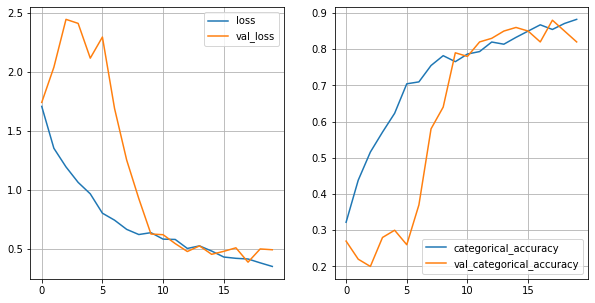

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history3.history['loss'])   
axes[0].plot(history3.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history3.history['categorical_accuracy'])   
axes[1].plot(history3.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<b>Observation:</b></br> This model has best validation accuracy at 18 epoch with 0.88  and train accuarcy 0f 0.85 but validation loss didn't improve after 18 epoch.

# Model-4 CNN_RNN Transfer Learning

In [38]:
from keras.applications import InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False)

In [13]:
class Transfer_InceptionModel(ModelBuilder):
    
    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(inception_model,
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))

        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
tl=Transfer_InceptionModel()
tl.set_path(project_folder)
tl.set_image_properties(image_height=128,image_width=128)
tl.set_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=25)
tl_rnn_model=tl.define_model()
tl_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 2, 2, 2048)   21802784  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 2, 2, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               8

D:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history4=tl.train_model(tl_rnn_model,augment_data=True)

C:\Users\Bhanu prakash\AppData\Local\Temp\ipykernel_16500\3549090176.py:125: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.7061 - categorical_accuracy: 0.3107
Epoch 1: val_loss improved from inf to 1.26548, saving model to model_init_2022-07-0918_12_21.192995\model-00001-1.70607-0.31071-1.26548-0.53000.h5
133/133 [==============================] - 220s 2s/step - loss: 1.7061 - categorical_accuracy: 0.3107 - val_loss: 1.2655 - val_categorical_accuracy: 0.5300 - lr: 2.0000e-04
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.0544 - categorical_accuracy: 0.5852
Epoch 2: val_loss improved from 1.26548 to 0.51481, saving model to model_init_2022-07-0918_12_21.192995\model-00002-1.05444-0.58522-0.51481-0.80000.h5
133/133 [==============================] - 206s 2s/step - loss: 1.0544 - categorical_accuracy: 0.5852 - val_loss: 0.5148 - val_categorical_accuracy: 0.8000 - lr: 2.0000e-04
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 0.5565 - categorical_accuracy: 0.8228
Epoch 3: val_loss improved fro

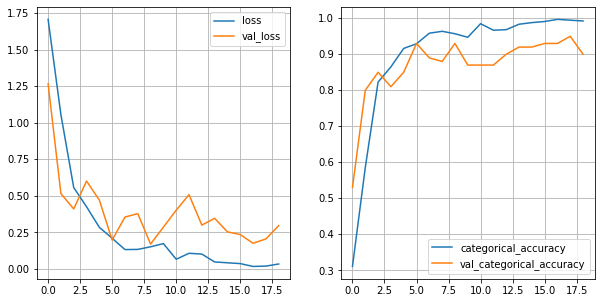

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history4.history['loss'])   
axes[0].plot(history4.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history4.history['categorical_accuracy'])   
axes[1].plot(history4.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<b>Observation:</b></br>With Inceptionv3 model transfer learning we got training accuracy of <b>0.96</b> and validation accuracy of <b>0.93</b> at 9 epoch

# Model-5 CNN_RNN Transfer Learning

In [41]:
class Transfer_InceptionModel_2(ModelBuilder):
    
    def define_model(self):

        model = Sequential()

        model.add(TimeDistributed(inception_model,
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))

        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
tl_2=Transfer_InceptionModel_2()
tl_2.set_path(project_folder)
tl_2.set_image_properties(image_height=128,image_width=128)
tl_2.set_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=25)
tl_2_rnn_model=tl_2.define_model()
tl_2_rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 2, 2, 2048)   21802784  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 2, 2, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [45]:
history5=tl_2.train_model(tl_2_rnn_model,augment_data=True)

C:\Users\Bhanu prakash\AppData\Local\Temp\ipykernel_9448\3598378733.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.8020 - categorical_accuracy: 0.2202
Epoch 1: val_loss improved from inf to 1.53926, saving model to model_init_2022-07-1010_04_03.887073\model-00001-1.80205-0.22021-1.53926-0.34000.h5
133/133 [==============================] - 260s 2s/step - loss: 1.8020 - categorical_accuracy: 0.2202 - val_loss: 1.5393 - val_categorical_accuracy: 0.3400 - lr: 2.0000e-04
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.5528 - categorical_accuracy: 0.3122
Epoch 2: val_loss improved from 1.53926 to 1.50659, saving model to model_init_2022-07-1010_04_03.887073\model-00002-1.55282-0.31222-1.50659-0.39000.h5
133/133 [==============================] - 201s 2s/step - loss: 1.5528 - categorical_accuracy: 0.3122 - val_loss: 1.5066 - val_categorical_accuracy: 0.3900 - lr: 2.0000e-04
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.1692 - categorical_accuracy: 0.5279
Epoch 3: val_loss improved fro

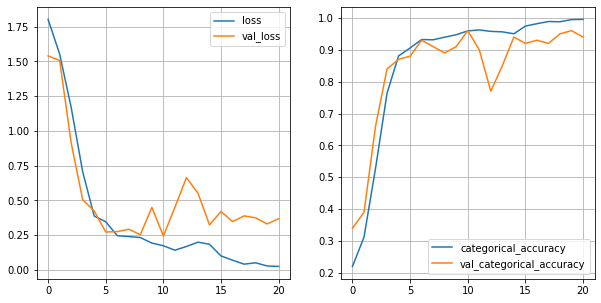

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(history5.history['loss'])   
axes[0].plot(history5.history['val_loss'])
axes[0].grid()
axes[0].legend(['loss','val_loss'])
axes[1].plot(history5.history['categorical_accuracy'])   
axes[1].plot(history5.history['val_categorical_accuracy'])
axes[1].grid()
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<b>Observation:</b> With the addition of new dense layer the validation accuracy got highest compared to all other models. This model achieved validation accuracy of <b>0.96</b> with train accuracy of <b>0.96</b> at 11th epoch

# Model Summaries

In [51]:
import pandas as pd
df=pd.DataFrame({"Experiment No":[1,2,3,4,5],"Model":["Conv3D","Conv3D","CNN_RNN","CNN_RNN_TR","CNN_RNN_TR"],"Train Accuracy":[0.95,0.92,0.85,0.95,0.96],"Validation Accuracy":[0.36,0.93,0.88,0.93,0.96],"Observation":["No image augmentation,Overfitting","Used image Augment,reduced batch,increased dense neurons & dropout rate","Used GRU with CNN","Used InceptionV3 ,reduced batch & increased epoch rate","Added new Dense layer with similar configuration to model4"]})

In [52]:
df.style.set_properties(subset=['Observation'], **{'width': '300px'})

,Experiment No,Model,Train Accuracy,Validation Accuracy,Observation
0,1,Conv3D,0.950000,0.360000,"No image augmentation,Overfitting"
1,2,Conv3D,0.920000,0.930000,"Used image Augment,reduced batch,increased dense neurons & dropout rate"
2,3,CNN_RNN,0.850000,0.880000,Used GRU with CNN
3,4,CNN_RNN_TR,0.950000,0.930000,"Used InceptionV3 ,reduced batch & increased epoch rate"
4,5,CNN_RNN_TR,0.960000,0.960000,Added new Dense layer with similar configuration to model4


# Load & test final model

In [61]:
from keras.models import load_model
# Load the final best model
final_model= load_model("model_init_2022-07-1010_04_03.887073\model-00011-0.17327-0.95928-0.24338-0.96000.h5")
# Create test generator
test_generator=Transfer_InceptionModel_2()
test_generator.set_path(project_folder)
test_generator.set_image_properties(image_height=128,image_width=128)
test_generator.set_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
print(batch_labels)
print(np.argmax(final_model.predict(batch_data[:,:,:,:,:]),axis=1))

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
1/1 [==============================] - 2s 2s/step
[3 3 1 4 3 3 3 1 4 3]
